# MNIST classifier

## Set up

In [1]:
# Imports
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision as tv
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
# Set parameters
batch_size_train = 64
batch_size_valid = 1000
learning_rate = 0.01
momentum = 0.9

## Get and format the data

In [3]:
def mnist_transform(img):
    """
    Transform a PIL image with shape (28, 28) to a tensor of shape(28 * 28)
    after normalizing using the MNIST dataset mean and variance
    
    Arguments:
    img -- PIL image
    
    Returns:
    output -- a tensor of shape (1, 28 * 28)
    """
    initial_transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.1307,), (0.3081,))
    ])
    output = initial_transform(img).view(28 * 28)
    return output

In [4]:
# Get the MNIST dataset, normalizing using the MNIST mean and variance
train_dset = tv.datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
valid_dset = tv.datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)
test_x, test_y = train_dset[1]
test_x.shape, test_y

(torch.Size([784]), 0)

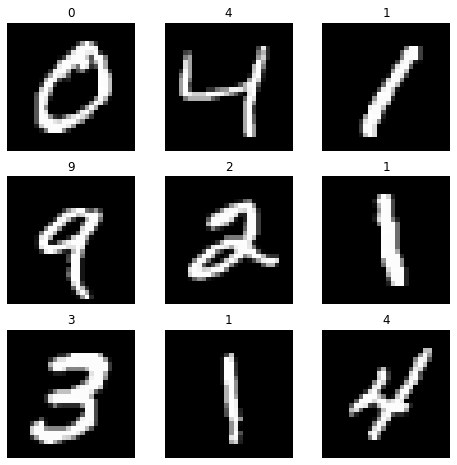

In [5]:
# Have a look at some images in the train dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    # sample_idx = torch.randint(len(train_dset), size=(1,)).item()
    sample_idx = i
    x, label = train_dset[sample_idx]
    img = x.reshape(1, 28, 28)
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
# Create dataloaders
train_dl = DataLoader(train_dset, batch_size=batch_size_train, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=batch_size_valid, shuffle=True)

In [7]:
# Check dataloader structure
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 784])
Labels batch shape: torch.Size([64])


# Define model

In [8]:
model = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,30),
    nn.ReLU(),
    nn.Linear(30,10)
)
for param in model.parameters():
    print(param.shape)

torch.Size([30, 784])
torch.Size([30])
torch.Size([30, 30])
torch.Size([30])
torch.Size([10, 30])
torch.Size([10])


In [9]:
# Initialise loss and optimiser
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
loss_fn=nn.CrossEntropyLoss()

In [10]:
# Test forward pass of single training example
test_pred = model(test_x).unsqueeze(0)
test_loss = loss_fn(test_pred, torch.tensor([test_y]))
test_pred

tensor([[ 0.0019, -0.0814,  0.1328,  0.1384, -0.1473, -0.1691,  0.0295,  0.0333,
         -0.1610, -0.0439]], grad_fn=<UnsqueezeBackward0>)

In [11]:
# Test forward pass of single batch
test_pred = model(train_features)
test_loss = loss_fn(test_pred, train_labels)
test_loss
print(test_pred.shape, train_labels.shape)
print(len(train_labels))

torch.Size([64, 10]) torch.Size([64])
64


In [12]:
# Calculate batch accuracy
def batch_accuracy(batch_pred, batch_labels):
    correct = (batch_pred.argmax(1) == batch_labels).type(torch.float).sum().item()
    return correct / len(batch_labels)

## Define training process

In [13]:
# Define training loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    current_examples, losses, accuracy = [], [], []
    for batch, (X, y) in enumerate(dataloader):
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            current_examples.append(current)
            losses.append(loss)
            accuracy.append(batch_accuracy(pred, y))
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return current_examples, losses, accuracy

In [14]:
def valid_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    valid_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {valid_loss:>8f} \n")
    return valid_loss, accuracy

## Train

In [15]:
# Set up global variables so we can train in steps without losing the current model state
train_examples, train_losses, train_accuracy = [], [], []
valid_examples, valid_accuracy = [0], [0]
current_epoch = 0

In [16]:
# Run the training
last_epoch = 10
for epoch in range(current_epoch, last_epoch):
    print(f"Epoch {epoch+1}\n-------------------------------")
    current_examples, losses, accuracy = train_loop(train_dl, model, loss_fn, optimizer)
    train_examples_to_add = np.array(current_examples) + (epoch * len(train_dl.dataset))
    train_examples.extend(train_examples_to_add.tolist())
    train_losses.extend(losses)
    train_accuracy.extend(accuracy)
    valid_epoch_loss, valid_epoch_accuracy = valid_loop(valid_dl, model, loss_fn)
    valid_examples.append((epoch + 1) * len(train_dl.dataset))
    valid_accuracy.append(valid_epoch_accuracy)
    current_epoch += 1
print("Done!")

Epoch 1
-------------------------------
loss: 2.295142  [    0/60000]
loss: 0.653924  [ 6400/60000]
loss: 0.321660  [12800/60000]
loss: 0.174862  [19200/60000]
loss: 0.166984  [25600/60000]
loss: 0.211110  [32000/60000]
loss: 0.207614  [38400/60000]
loss: 0.078478  [44800/60000]
loss: 0.356958  [51200/60000]
loss: 0.220709  [57600/60000]
Test Error: 
 Accuracy: 94.5%, Avg loss: 0.184867 

Epoch 2
-------------------------------
loss: 0.181205  [    0/60000]
loss: 0.313632  [ 6400/60000]
loss: 0.221884  [12800/60000]
loss: 0.274810  [19200/60000]
loss: 0.210111  [25600/60000]
loss: 0.192567  [32000/60000]
loss: 0.133536  [38400/60000]
loss: 0.037227  [44800/60000]
loss: 0.202893  [51200/60000]
loss: 0.146581  [57600/60000]
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.144901 

Epoch 3
-------------------------------
loss: 0.058735  [    0/60000]
loss: 0.211491  [ 6400/60000]
loss: 0.137083  [12800/60000]
loss: 0.276242  [19200/60000]
loss: 0.060571  [25600/60000]
loss: 0.264924  [32000/600

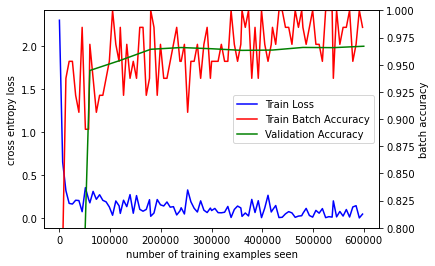

In [17]:
# Plot results
fig, ax1 = plt.subplots()
#ax1.set_ylim(bottom=2)
plt_train_losses, = ax1.plot(train_examples, train_losses, color='blue', label='Train Loss')
ax2 = ax1.twinx()
ax2.set_ylim(bottom=0.8)
plt_train_accuracy, = ax2.plot(train_examples, train_accuracy, color='red', label='Train Batch Accuracy')
plt_valid_accuracy, = ax2.plot(valid_examples, valid_accuracy, color='green', label='Valid Batch Accuracy')
ax1.legend(
    [plt_train_losses, plt_train_accuracy, plt_valid_accuracy],
    ['Train Loss', 'Train Batch Accuracy', 'Validation Accuracy'],
    loc=7
)
ax1.set_xlabel('number of training examples seen')
ax1.set_ylabel('cross entropy loss')
ax2.set_ylabel('batch accuracy');

# Results

The model quickly finds a "good" solution. By continuing training for a long time, we can see that training accuracy starts to creep up higher than validation accuracy, showing over-fitting.

Note that the shape of the train batch accuracy curve is given by the discrete nature of the number of correct values - for example in later epochs the accuracy tends to be either 100%, 98.44%, or 96.88% - corresponding to 64, 63 or 62 correct predictions out of each batch of 64 examples.